In [ ]:
import tensorflow as tf 
import numpy as np 
from src import layers, utils, models
import matplotlib.pyplot as plt 
from importlib import reload 
reload(layers)
reload(models)

In [156]:
B = 30  # Batch Size
C = 50  # Context Length
I = 2  # Input dim
D = 2  # Output dim
H = 3  # Heads/Layers
N = 4  # Segments
T = C*N  # Total series length

model = models.InfiniAttentionModel(dims=D, heads=H, context_length=C)
model.compile("adam", "mse")

li = tf.keras.Input(shape=(None, I))
cells = [tf.keras.layers.LSTMCell(units=5, activation="elu") for _ in range(H-1)]
cells.append(tf.keras.layers.LSTMCell(units=2, activation="linear"))
lstm = tf.keras.layers.RNN(
    tf.keras.layers.StackedRNNCells(cells),
    return_sequences=True, return_state=False)
lo = lstm(li)
lstm_model = tf.keras.models.Model(li, lo)
lstm_model.compile("adam", "mse")

In [157]:
xt = utils.generate_sin(length=T, samples=B)
xt = tf.transpose(xt, (2, 0, 1))

x_in = []
for t in range(N):
    x_in.append(xt[:, t*C:((t+1)*C)][:, None, :, :])
x_in = tf.concat(x_in, axis=1)

In [ ]:
epochs = 400

history = model.fit(x_in, x_in, epochs=400, batch_size=50)
o = model(x_in)
oinf = o.numpy().reshape(B, -1, 2)

lstm_history = lstm_model.fit(xt, xt, epochs=400, batch_size=50)
olstm = lstm_model(xt)
olstm = olstm.numpy().reshape(B, -1, 2)

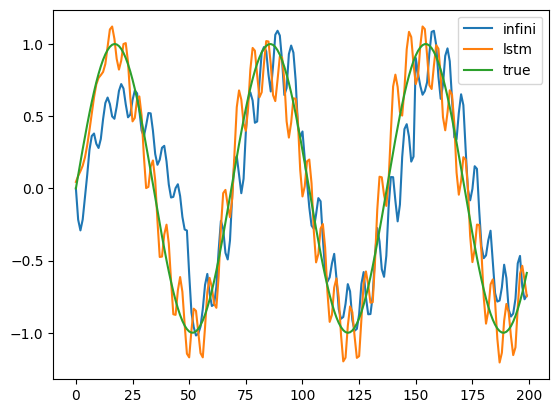

In [159]:
plt.plot(oinf[0, :, 0], label="infini")
plt.plot(olstm[0, :, 0], label="lstm")
plt.plot(xt[0, :, 0], label="true")
plt.legend()

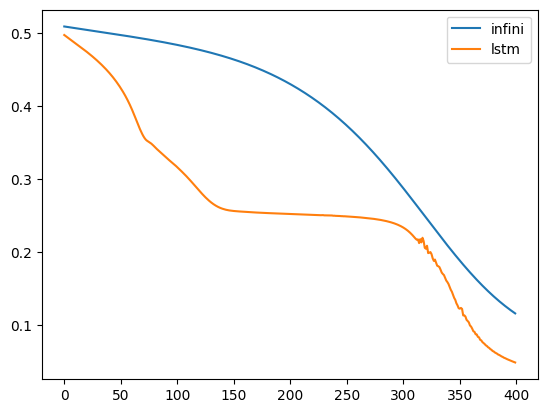

In [160]:
hi = history.history["loss"]
hl = lstm_history.history["loss"]

plt.plot(hi, label="infini")
plt.plot(hl, label="lstm")
plt.legend()